# IF + F regression + ELM


In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import f_regression, SelectKBest  # F-regresyon için gerekli modül

df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özelliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]


mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [12]:
# Isolation Forest
data_for_outlier = X.copy()
data_for_outlier[target] = y

# IsolationForest modelini, contamination parametresi "auto" olarak tanımlıyoruz
iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
outlier_pred = iso_forest.fit_predict(data_for_outlier)

# Aykırı olmayan örnekler: etiket 1, aykırı olanlar: -1
mask = outlier_pred == 1
print(f"Toplam örnek sayısı: {len(data_for_outlier)}")
print(f"Aykırı tespit edilen örnek sayısı: {np.sum(outlier_pred == -1)}")

# Temizlenmiş veri seti (aykırı değerler çıkarıldı)
X_clean = X[mask]
y_clean = y[mask]


Toplam örnek sayısı: 1692
Aykırı tespit edilen örnek sayısı: 286


In [13]:
# F-Regresyon
selector = SelectKBest(score_func=f_regression, k=10)
X_clean_selected = selector.fit_transform(X_clean, y_clean)

# Seçilen özniteliklerin indekslerini ve isimle
selected_indices = selector.get_support(indices=True)
selected_features = X_clean.columns[selected_indices]
print("Seçilen öznitelikler:", list(selected_features))

Seçilen öznitelikler: ['basarili_satis_ciro', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'USD_Yüksek', 'Yıl', 'Ay']


In [14]:
# ELM Regressor
class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=50, activation='sigmoid', random_state=None):
        self.n_hidden = n_hidden
        self.activation = activation
        self.random_state = random_state

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Bilinmeyen aktivasyon fonkyonu.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)
        # Rastgele input ağırlıkları ve bias değerleri oluşturuluyor
        self.input_weights_ = rng.randn(n_features, self.n_hidden)
        self.bias_ = rng.randn(self.n_hidden)
        # Gizli katmanın çıktısı hesaplanıyor
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        # Çıkış ağırlıkları, H'nin pseudoinverse'i ile y'ye göre çözümleniyor
        self.beta_ = np.linalg.pinv(H).dot(y)
        return self

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        return np.dot(H, self.beta_)


elm_model = ELMRegressor(n_hidden=50, activation='sigmoid', random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross validation sırasında seçilen öznitelikler kullanır
y_pred = cross_val_predict(elm_model, X_clean_selected, y_clean, cv=kfold)


# Model Performansını
mae = mean_absolute_error(y_clean, y_pred)
mape = mean_absolute_percentage_error(y_clean, y_pred)
r2 = r2_score(y_clean, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R2 Score: {r2}")



Mean Absolute Error (MAE): 2.264431615742031
Mean Absolute Percentage Error (MAPE): 1.0994732913959602
R2 Score: -9681.579958767492


C:\Users\yagiz\AppData\Local\Temp\ipykernel_2220\1511536849.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


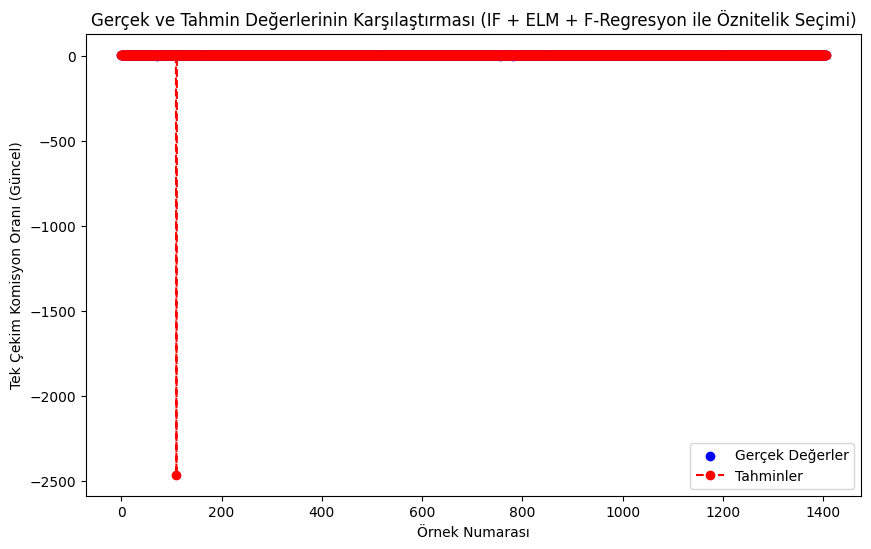

In [15]:

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean)), y_clean, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred)), y_pred, color="red", label="Tahminler", linestyle="--", marker="o")
plt.title("Gerçek ve Tahmin Değerlerinin Karşılaştırması (IF + ELM + F-Regresyon ile Öznitelik Seçimi)")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()
plt.show()


Anormal tahminlerin indeksleri: [110]


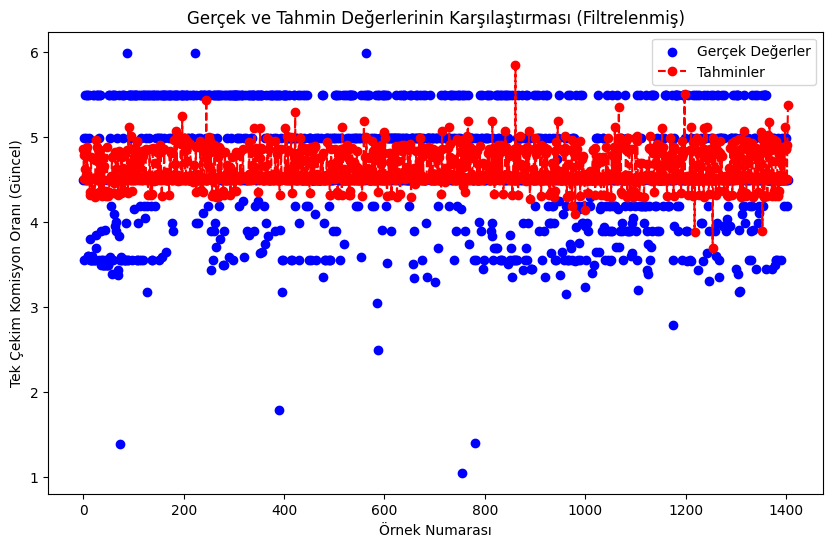

In [ ]:
anormal_index = np.where(y_pred < -2000)[0]
print("Anormal tahminlerin indeksleri:", anormal_index)

# mask
mask_anormal = y_pred >= -2000
y_pred_filtered = y_pred[mask_anormal]
y_clean_filtered = y_clean[mask_anormal]

# Filtrelenmiş tahmin ve gerçek değerlerle görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean_filtered)), y_clean_filtered, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred_filtered)), y_pred_filtered, color="red", linestyle="--", marker="o", label="Tahminler")
plt.title("Gerçek ve Tahmin Değerlerinin Karşılaştırması (Filtrelenmiş)")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()

plt.show()


In [ ]:

anormal_indices = np.where(y_pred < -2000)[0]
print("Anormal tahminlerin indeksleri:", anormal_indices)


features_anormal = X_clean.iloc[anormal_indices]
y_actual_anormal = y_clean.iloc[anormal_indices]
y_pred_anormal = y_pred[anormal_indices]


anormal_df = features_anormal.copy()
anormal_df['Gerçek Değer'] = y_actual_anormal.values
anormal_df['Tahmin Edilen Değer'] = y_pred_anormal

print("Anormal tahmin yapılan örneklerin özellikleri, gerçek ve tahmin edilen değerleri:")
print(anormal_df)


Anormal tahminlerin indeksleri: [110]
Anormal tahmin yapılan örneklerin özellikleri, gerçek ve tahmin edilen değerleri:
     mccinfo  Şehir  İlçe  basarili_satis_adet  basarili_satis_ciro  \
236       17     60    40                    1                  1.0   

     basarili_iade_adet  basarili_iade_ciro  Müşteri Skoru  bıst100_Kapanış  \
236                   0                 0.0          49.62            2.394   

     bıst100_Açılış  ...  Euro_Düşük  USD_Kapanış  USD_Açılış  USD_Yüksek  \
236           2.401  ...       16.18      15.8951     15.5493     15.9469   

     USD_Düşük   Yıl  Ay  Gün  Gerçek Değer  Tahmin Edilen Değer  
236     15.492  2022   5   17          1.79         -2463.174805  

[1 rows x 25 columns]


In [8]:
mae = mean_absolute_error(y_clean_filtered, y_pred_filtered )
mape = mean_absolute_percentage_error(y_clean_filtered, y_pred_filtered )
r2 = r2_score(y_clean_filtered, y_pred_filtered )

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R2 Score: {r2}")

Mean Absolute Error (MAE): 0.5116199623101755
Mean Absolute Percentage Error (MAPE): 0.12013105894764059
R2 Score: 0.03588445553020769
